# Road name analysis
*April 22, 2022*

A look at how many roads are named for colonizers, slaveowners, or other potentially bad people from history. Start by importing geopandas.

In [4]:
import geopandas
import contextily as cx

Now read in this massive dataset, straight from StatsCan.

In [5]:
raw = geopandas.read_file("https://www12.statcan.gc.ca/census-recensement/2021/geo/sip-pis/RNF-FRR/files-fichiers/lrnf000r21a_e.zip")

raw.head()

,OBJECTID,NGD_UID,NAME,TYPE,DIR,AFL_VAL,ATL_VAL,AFR_VAL,ATR_VAL,CSDDGUID_L,...,CSDTYPE_R,PRDGUID_L,PRUID_L,PRNAME_L,PRDGUID_R,PRUID_R,PRNAME_R,RANK,CLASS,geometry
0,1,5792582,des 60,RANG,None,195,195,182,194,2021A00052457050,...,MÉ,2021A000224,24,Quebec / Québec,2021A000224,24,Quebec / Québec,4,23,"LINESTRING (7650137.494 1271488.229, 7650168.1..."
1,2,4744971,Township Road 734,None,None,None,None,None,None,2021A00054819006,...,MD,2021A000248,48,Alberta,2021A000248,48,Alberta,5,22,"LINESTRING (4530157.094 2497211.194, 4530155.7..."
2,3,1935694,733 Grid,RD,None,None,None,None,None,2021A00054706063,...,RM,2021A000247,47,Saskatchewan,2021A000247,47,Saskatchewan,4,23,"LINESTRING (5262271.166 1735451.494, 5263851.4..."
3,4,1618738,None,None,None,None,None,None,None,2021A00054704011,...,RM,2021A000247,47,Saskatchewan,2021A000247,47,Saskatchewan,5,23,"LINESTRING (4983198.517 1610947.486, 4983562.1..."
4,5,5055161,Maple,ST,None,None,None,None,None,2021A00054706027,...,CY,2021A000247,47,Saskatchewan,2021A000247,47,Saskatchewan,5,23,"LINESTRING (5302070.049 1686499.574, 5302090.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242112,2242113,5759589,du Barrage,CH,None,155,189,156,168,2021A00052483055,...,MÉ,2021A000224,24,Quebec / Québec,2021A000224,24,Quebec / Québec,5,23,"LINESTRING (7438650.543 1282236.543, 7438651.6..."
2242113,2242114,5236704,28,HWY,None,None,None,None,None,2021A00054812004,...,MD,2021A000248,48,Alberta,2021A000248,48,Alberta,2,21,"LINESTRING (5043893.926 2187305.757, 5043892.5..."
2242114,2242115,4238414,Beaver,DR,None,None,None,None,None,2021A00054803014,...,T,2021A000248,48,Alberta,2021A000248,48,Alberta,4,23,"LINESTRING (4633913.897 1757862.446, 4633910.3..."
2242115,2242116,4238415,Beaver,DR,None,None,None,None,None,2021A00054803014,...,T,2021A000248,48,Alberta,2021A000248,48,Alberta,4,23,"LINESTRING (4633914.954 1757839.006, 4633914.3..."


Because this dataset is so large, I want to avoid making changes directly to it, so I'll make a copy of the raw file for working with.

In [10]:
data = raw.copy()

In order to avoid issues with capitals etc, I'll make every street name uppercase.

In [ ]:
data["NAME"] = data["NAME"].str.upper()

Now we define a list of names we want to search for.

In [11]:
names = ["DUNDAS"]

...and then search the NAME column for those names.

In [14]:
dundas = data[data["NAME"].isin(names)]

dundas.sample(5)

,OBJECTID,NGD_UID,NAME,TYPE,DIR,AFL_VAL,ATL_VAL,AFR_VAL,ATR_VAL,CSDDGUID_L,...,CSDTYPE_R,PRDGUID_L,PRUID_L,PRNAME_L,PRDGUID_R,PRUID_R,PRNAME_R,RANK,CLASS,geometry
1009601,1009602,5033601,DUNDAS,ST,W,1269,1287,1272,1274,2021A00053520005,...,C,2021A000235,35,Ontario,2021A000235,35,Ontario,4,23,"LINESTRING (7221534.171 927610.463, 7221493.41..."
1964204,1964205,5698121,DUNDAS,ST,W,481,495,488,506,2021A00053512005,...,CY,2021A000235,35,Ontario,2021A000235,35,Ontario,3,12,"LINESTRING (7371335.397 1017427.340, 7371219.4..."
210018,210019,5079159,DUNDAS,ST,None,None,None,None,None,2021A00053532042,...,CY,2021A000235,35,Ontario,2021A000235,35,Ontario,5,22,"LINESTRING (7125883.946 849902.226, 7125883.51..."
619364,619365,494177,DUNDAS,ST,W,None,None,None,None,2021A00053520005,...,C,2021A000235,35,Ontario,2021A000235,35,Ontario,4,22,"LINESTRING (7218616.057 928650.640, 7218579.90..."
911574,911575,514517,DUNDAS,ST,W,1960,1960,1963,2021,2021A00053521005,...,CY,2021A000235,35,Ontario,2021A000235,35,Ontario,4,21,"LINESTRING (7204568.040 911494.646, 7204423.13..."


<AxesSubplot:>

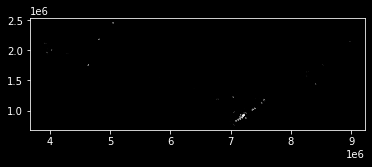

In [15]:
fig = dundas.plot(alpha=0.6)
cx.add_basemap(fig)

That's it for now.

\-30\-